In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import pandas as pd
from pathlib import Path

# Import our model from mediumModel.py
from mediumModel import (
    EnhancedFeatureExtractionNetwork,
    EnhancedPhaseCorrelationTensorComputation,
    DimensionAdapter,
    ManifoldLearningModule,
    PointCloudGenerator,
    TinyTopologicalFeatureExtraction,
    ClassificationNetwork,
    ImagePreprocessor
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Initialize model components from mediumModel.py with medium-sized parameters
feature_network = EnhancedFeatureExtractionNetwork(feature_dim=256).to(device)
tensor_computer = EnhancedPhaseCorrelationTensorComputation(feature_dim=256, output_dim=512).to(device)

# Create the dimension adapter
dim_adapter = DimensionAdapter(input_dim=512, output_dim=256).to(device)

# Initialize the manifold module
manifold_module = ManifoldLearningModule(
    input_dim=256,
    hidden_dim=512,
    latent_dim=64,
    gnn_hidden_dim=128
).to(device)

# For topological analysis, we need to create point clouds from manifold features
point_cloud_generator = PointCloudGenerator(num_points=64).to(device)

# Use TinyTopologicalFeatureExtraction from mediumModel.py
topo_module = TinyTopologicalFeatureExtraction(
    input_dim=64,           # Match the output dimension from ManifoldLearningModule
    hidden_dim=64,          # Hidden dimension
    output_dim=32,          # Output dimension
    max_edge_length=2.0,    # Maximum edge length for filtration
    num_filtrations=16,     # Number of filtration values
    max_dimension=1         # Increased to dimension 1 for medium model
).to(device)

# ClassificationNetwork from mediumModel.py
classifier = ClassificationNetwork(
    manifold_dim=64,        # Match the output dimension from ManifoldLearningModule
    topo_dim=32,            # Match the output dimension from TinyTopologicalFeatureExtraction
    feature_dim=128,        # Feature dimension
    hidden_dim=256,         # Hidden dimension
    num_layers=4,           # Number of transformer layers
    num_heads=6,            # Number of attention heads
    dropout=0.15            # Dropout rate
).to(device)

# Print model sizes using count_parameters from test_medium_model.py
from test_medium_model import count_parameters

print(f"Enhanced Feature Extraction Network: {count_parameters(feature_network):,} parameters")
print(f"Phase Correlation Tensor Computation: {count_parameters(tensor_computer):,} parameters")
print(f"Dimension Adapter: {count_parameters(dim_adapter):,} parameters")
print(f"Manifold Learning Module: {count_parameters(manifold_module):,} parameters")
print(f"Point Cloud Generator: {count_parameters(point_cloud_generator):,} parameters")
print(f"Tiny Topological Feature Extraction: {count_parameters(topo_module):,} parameters")
print(f"Classification Network: {count_parameters(classifier):,} parameters")
total_params = (count_parameters(feature_network) + count_parameters(tensor_computer) + 
               count_parameters(dim_adapter) + count_parameters(manifold_module) + 
               count_parameters(point_cloud_generator) + count_parameters(topo_module) + 
               count_parameters(classifier))
print(f"Total: {total_params:,} parameters")

Using device: cuda
Enhanced Feature Extraction Network: 23,825,059 parameters
Phase Correlation Tensor Computation: 7,324,353 parameters
Dimension Adapter: 1,869,184 parameters
Manifold Learning Module: 12,427,264 parameters
Point Cloud Generator: 97 parameters
Tiny Topological Feature Extraction: 4,256 parameters
Classification Network: 1,084,580 parameters
Total: 46,534,793 parameters



Loading from: C:\Users\athar\Documents\GitHub\P.C.M\images\ai_vs_human_generated_dataset\train.csv
CSV columns: ['Unnamed: 0', 'file_name', 'label']
First few rows of the CSV:
   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
Successfully loaded 79950 images from C:\Users\athar\Documents\GitHub\P.C.M\images\ai_vs_human_generated_dataset\train.csv
Human images (label 0): 39975
AI-generated images (label 1): 39975
Dataset 1: 79950 images loaded

Loading from: C:\Users\athar\Documents\GitHub\P.C.M\ai_vs_human_gener\train.csv
CSV columns: ['image_path', 'label']
First few rows of the CSV:
                           image_path

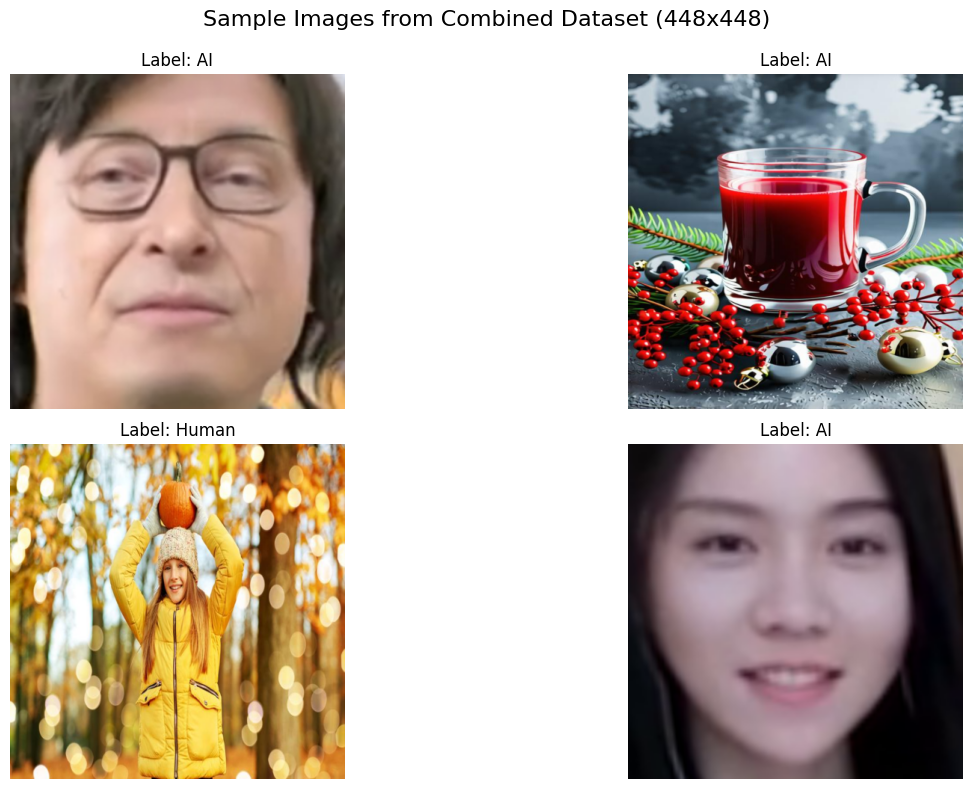


Demonstrating upsampling:
Original image size: (224, 224)
Image path: C:\Users\athar\Documents\GitHub\P.C.M\ai_vs_human_gener\train_data\train_image_42009_AI.png
Label: AI


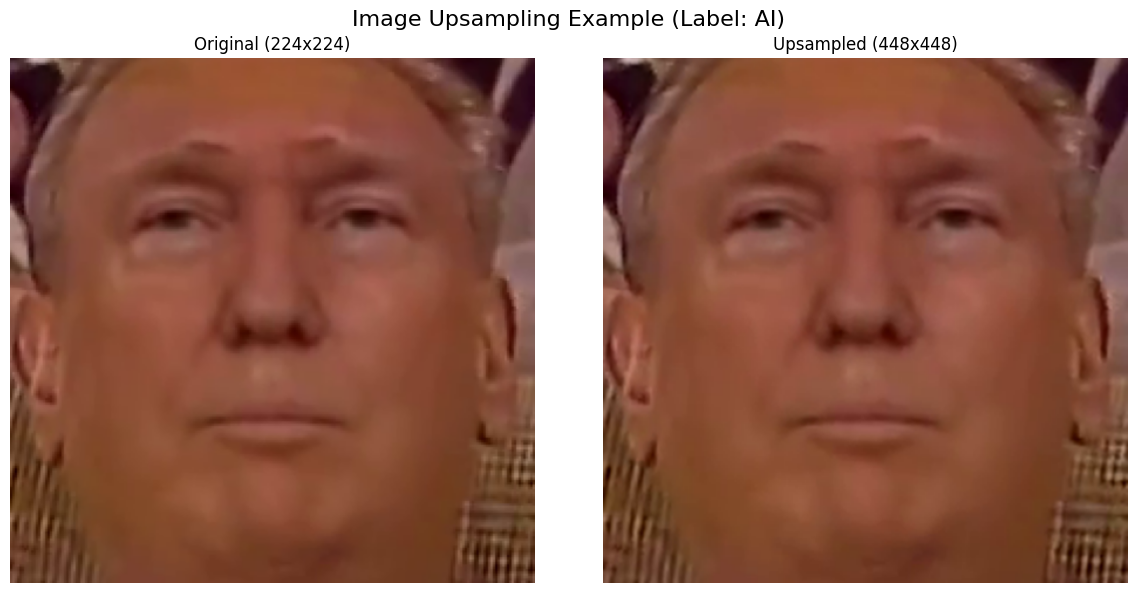


Example of iterating through the data loader:
Batch shape: torch.Size([4, 3, 448, 448])
Labels: tensor([1, 0, 0, 1])
First batch shown as example. Ready for model training.


In [ ]:
# Custom dataset class with upsampling to 448x448
class CustomImageDataset(Dataset):
    def __init__(self, image_files, labels, target_size=(448, 448)):
        self.image_files = image_files
        self.labels = labels
        self.target_size = target_size
        
        # Define transforms using standard torchvision transformations
        self.transform = transforms.Compose([
            transforms.Resize(target_size),  # Upsample to 448x448
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        label = self.labels[idx]
        
        try:
            # Open image with PIL and convert to RGB
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                img_tensor = self.transform(img)
                return img_tensor, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a placeholder tensor and the label
            return torch.ones(3, *self.target_size), label

def load_dataset_from_csv(csv_path, verbose=True):
    """Load image paths and labels from a CSV file"""
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    if verbose:
        print(f"\nLoading from: {csv_path}")
        print(f"CSV columns: {df.columns.tolist()}")
        print(f"First few rows of the CSV:\n{df.head()}")
    
    # Get the base path for the images
    base_path = os.path.dirname(csv_path)
    
    # Parse file paths and labels from CSV
    all_files = []
    labels = []
    
    # Extract file paths and labels from the DataFrame
    for index, row in df.iterrows():
        # Handle different column names for file paths
        if 'image_path' in df.columns:
            file_name = row['image_path']
        elif 'file_name' in df.columns:
            file_name = row['file_name']
        else:
            raise ValueError(f"Could not find image path column in CSV: {csv_path}")
        
        # Construct full file path
        file_path = os.path.join(base_path, file_name)
        
        # Handle different label formats
        if 'label' in df.columns:
            # Check if label is already a number or a string
            if isinstance(row['label'], (int, float)) or str(row['label']).isdigit():
                label = int(row['label'])
            else:
                # If label is in text format (AI or Human)
                label_text = str(row['label']).lower()
                label = 1 if label_text == 'ai' else 0
        else:
            raise ValueError(f"Could not find label column in CSV: {csv_path}")
        
        # Try multiple path resolutions
        if os.path.exists(file_path):
            all_files.append(file_path)
            labels.append(label)
        else:
            # Try with just the basename
            alt_path = os.path.join(base_path, os.path.basename(file_name))
            if os.path.exists(alt_path):
                all_files.append(alt_path)
                labels.append(label)
            else:
                # Try looking in a standard subdirectory
                for subdir in ['train_data', 'images', 'data']:
                    alt_path = os.path.join(base_path, subdir, os.path.basename(file_name))
                    if os.path.exists(alt_path):
                        all_files.append(alt_path)
                        labels.append(label)
                        break
                else:  # Executed if the for loop completes normally (no break)
                    if verbose and index < 10:  # Only show first few warnings
                        print(f"Warning: File not found: {file_path}")
    
    if verbose:
        print(f"Successfully loaded {len(all_files)} images from {csv_path}")
        print(f"Human images (label 0): {labels.count(0)}")
        print(f"AI-generated images (label 1): {labels.count(1)}")
    
    return all_files, labels

def combine_datasets():
    """Load and combine datasets from both CSV files"""
    # Paths to the CSV files
    csv_path1 = r'C:\Users\athar\Documents\GitHub\P.C.M\images\ai_vs_human_generated_dataset\train.csv'
    csv_path2 = r'C:\Users\athar\Documents\GitHub\P.C.M\ai_vs_human_gener\train.csv'
    
    # Load datasets
    try:
        files1, labels1 = load_dataset_from_csv(csv_path1)
        print(f"Dataset 1: {len(files1)} images loaded")
    except Exception as e:
        print(f"Error loading dataset 1: {e}")
        files1, labels1 = [], []
    
    try:
        files2, labels2 = load_dataset_from_csv(csv_path2)
        print(f"Dataset 2: {len(files2)} images loaded")
    except Exception as e:
        print(f"Error loading dataset 2: {e}")
        files2, labels2 = [], []
    
    # Combine the datasets
    all_files = files1 + files2
    all_labels = labels1 + labels2
    
    print(f"\nCombined dataset statistics:")
    print(f"Total images: {len(all_files)}")
    print(f"Human images (label 0): {all_labels.count(0)}")
    print(f"AI-generated images (label 1): {all_labels.count(1)}")
    
    return all_files, all_labels

def create_and_visualize_dataset():
    """Create dataset, split it, and visualize samples"""
    # Combine datasets
    all_files, all_labels = combine_datasets()
    
    if len(all_files) == 0:
        print("No images were loaded. Please check file paths.")
        return None, None
    
    # Create the dataset with upsampling to 448x448
    dataset = CustomImageDataset(all_files, all_labels, target_size=(448, 448))
    
    # Split the dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    print(f"\nDataset split:")
    print(f"Training set: {train_size} images")
    print(f"Validation set: {val_size} images")
    
    # Create data loaders
    batch_size = 4  # Increased batch size slightly
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Check a batch of data and show upsampled images
    try:
        images, labels = next(iter(train_loader))
        print(f"Batch shape: {images.shape}")
        print(f"Sample labels: {labels}")
        
        # Visualize sample images
        plt.figure(figsize=(15, 8))
        for i in range(min(batch_size, len(images))):
            plt.subplot(2, batch_size//2, i+1)
            img = images[i].permute(1, 2, 0).numpy()
            # Clip values to valid range for display
            img = np.clip(img, 0, 1)
            plt.imshow(img)
            plt.title(f"Label: {'Human' if labels[i] == 0 else 'AI'}")
            plt.axis('off')
        plt.tight_layout()
        plt.suptitle("Sample Images from Combined Dataset (448x448)", fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()
        
        # Show upsampling effect on a single image
        if len(all_files) > 0:
            # Select a random image to demonstrate upsampling
            img_idx = np.random.randint(0, len(all_files))
            # Load original image
            original_img = Image.open(all_files[img_idx]).convert('RGB')
            original_size = original_img.size
            print(f"\nDemonstrating upsampling:")
            print(f"Original image size: {original_size}")
            print(f"Image path: {all_files[img_idx]}")
            print(f"Label: {'Human' if all_labels[img_idx] == 0 else 'AI'}")
            
            # Create upsampled version
            upsampled_img = original_img.resize((448, 448), Image.LANCZOS)
            
            # Display comparison
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(original_img)
            plt.title(f"Original ({original_size[0]}x{original_size[1]})")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(upsampled_img)
            plt.title("Upsampled (448x448)")
            plt.axis('off')
            
            plt.suptitle(f"Image Upsampling Example (Label: {'Human' if all_labels[img_idx] == 0 else 'AI'})", fontsize=16)
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()
        
    except Exception as e:
        import traceback
        print(f"Error visualizing data: {e}")
        traceback.print_exc()
    
    return train_loader, val_loader

# Run the main function
if __name__ == "__main__":
    train_loader, val_loader = create_and_visualize_dataset()
    
    # Example of how to use the data loaders for training
    if train_loader is not None:
        print("\nExample of iterating through the data loader:")
        # Get a single batch
        for images, labels in train_loader:
            print(f"Batch shape: {images.shape}")
            print(f"Labels: {labels}")
            print("First batch shown as example. Ready for model training.")
            break